In [1]:
#回帰について学ぶ
#housing priceデータセットを使って学習を進める

import pandas as pd
import os 
import numpy as np

#house price df load
cdir = os.getcwd()

df_path = os.path.join(cdir,'python-machine-learning-book-3rd-edition/ch10/housing.data.txt')

#txtファイルも、区切り文字を指定することでdfとして読める
df = pd.read_csv(df_path,header=None,sep='\s+')
df.columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']

df.head()
#print(df.shape) 506*14

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


目的変数はMEDVということで進める

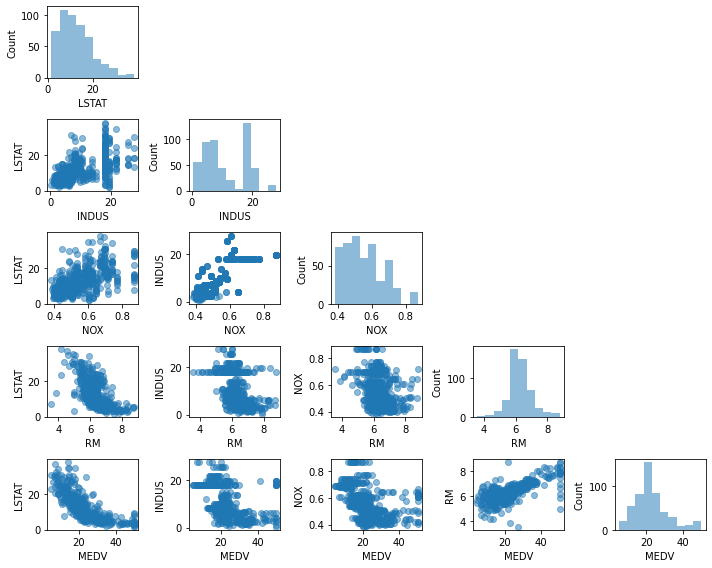

In [2]:
#散布図行列をつくってみる
#tidyverseのggplot的な相関係数と分布を一度に確認できるようなやつ
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix#mlxtendのscatteplormatrixってやつ

#decide cols
cols = ['LSTAT','INDUS','NOX','RM','MEDV']

#変数のペア関係をプロット
scatterplotmatrix(df[cols].values,figsize=(10,8),names=cols,alpha=.5)
plt.tight_layout()
plt.show()

<AxesSubplot:>

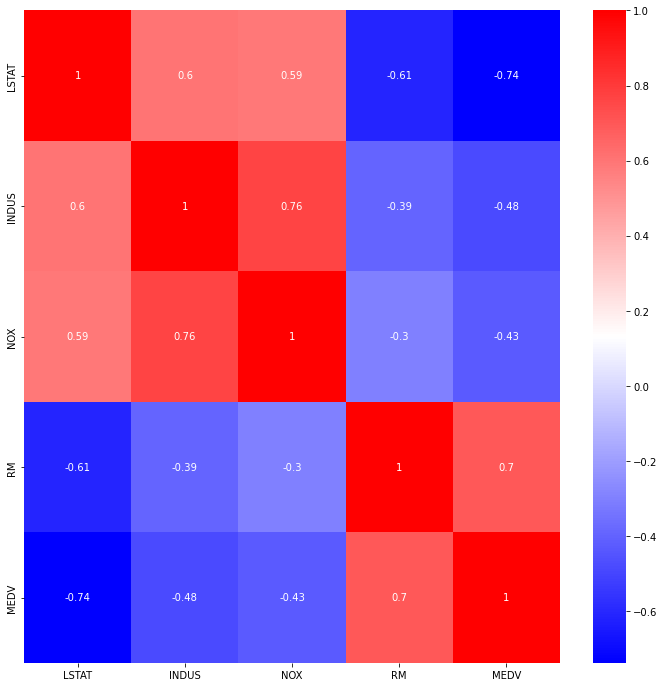

In [3]:
#つぎに、相関係数行列を作成
plt.figure(figsize=(12,12))
#5つの特徴量に限定
sns.heatmap(data=df[cols].corr(),cmap='bwr',annot=True)

線形モデルを適合させるときに重要なのは、目的変数と相関係数の高い特徴量<br>
この場合、LSTATが-0.74ともっとも高い相関があることがわかり、次にRMが0.7と高い<br>
<br>
ただし、MEDVとLSTATは散布図行列を見ると非線形の関係性であることがわかるが、MEDVとRMは線形っぽい関係性<br>
また、特徴量同士のRMとLSTAT同士の相関係数も-0.61と比較的高い

In [4]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)
    
lk = LinearRegressionGD()
#エラーでてFITデキナイ　マジクソ
#lk.fit(X,y)

In [5]:
#動作確認
from sklearn.linear_model import LinearRegression

X = df[['RM']].values
y = df[['MEDV']].values
from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

lr = LinearRegression()
lr.fit(X_std, y_std)

LinearRegression()

In [6]:
LinearRegression.__init__

print(lr.score(X_std,y_std))
#重みの確認
print(lr.coef_)
#切片の確認
print(lr.intercept_)

0.483525455991334
[[0.69535995]]
[-4.43892061e-16]


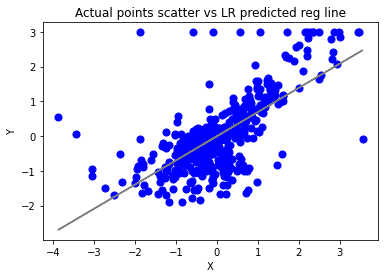

In [7]:
#plot
def lin_regplot(X,y,model):
    #X,yの散布図
    plt.scatter(X,y,c='blue',s=50)
    #predict結果を線として描画
    plt.plot(X,model.predict(X),c='gray')
    plt.title('Actual points scatter vs LR predicted reg line')
    plt.xlabel('X')
    plt.ylabel('Y')
lin_regplot(X_std,y_std,lr)

0.48352545599133423


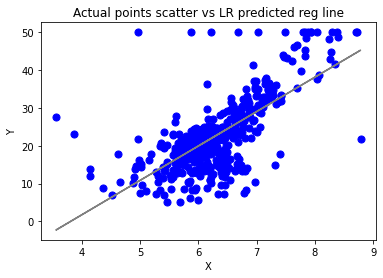

In [8]:
#データ標準化をしないで線形回帰した場合
lr2 = LinearRegression()
lr2.fit(X,y)

print(lr2.score(X,y))
lin_regplot(X,y,lr2)#同じようにうまく学習できている

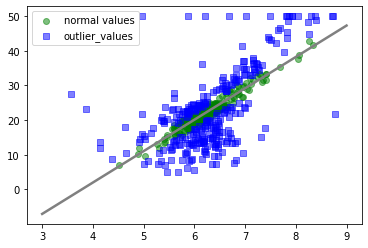

In [11]:
#外れ値に対応する手法 RANSACRegressor
from sklearn.linear_model import RANSACRegressor

"""
RANSACRegressorとは、データから外れ値を除外し、外れ値じゃないデータポイントでだけ学習をおこなうアルゴリズム
外れ値がどこからか？といった閾値の指定や、学習に使うアルゴリズムはユーザーが指定できる

"""
#instance
RR = RANSACRegressor(LinearRegression(),
                     max_trials=100,#iteration num
                     min_samples=50,#randomに選択される訓練データの数を50に設定
                     #1.正常値として学習させるランダムなデータポイント
                     loss='squared_error',#一つのデータポイントの推定vs実際の誤差計測は、誤差の二乗で行う
                     residual_threshold=5.0,#学習直線の予測と実測値の誤差が、5単位以内を正常値として学習に使う
                                            #5単位というのは、yの標準偏差の話で、残差が5単位以内のデータのみ正常値として使う
                     #正常値以外のすべてのデータポイントに対して、ここで指定した閾値に入るデータポイントを
                     #学習データとして追加で学習
                     
                     random_state=0)

RR.fit(X,y)

#正常値と異常値のマスク配列
normal_mask = RR.inlier_mask_#正常値を表す真偽値
outlier_mask = np.logical_not(RR.inlier_mask_)#外れ値を表す真偽値

#テキトーに3から9のXの配列を作成
line_X = np.arange(3,10,1)
#それをRANSACRegressorにぶちこんだときの予測値
line_y_ransac = RR.predict(line_X.reshape(-1,1))

#正常値をプロット
plt.scatter(X[normal_mask],y[normal_mask],c='g',label='normal values',marker='o',alpha=.5)
#外れ値をプロット
plt.scatter(X[outlier_mask],y[outlier_mask],c='b',label='outlier_values',marker='s',alpha=.5)
#RANSACRegressorによる予測値をプロット
plt.plot(line_X,line_y_ransac,color='gray',lw=2.5)
plt.legend()

In [12]:
#外れ値を除外したことで、線形モデルの切片と係数が、通常のLRとRansacだと少し異なる結果になった
print('LRの係数:{} LRの切片:{}'.format(lr2.coef_[0],lr2.intercept_))
print('RANSAC Regressorの係数:{} RANSAC Regressorの切片:{}'.format(RR.estimator_.coef_[0],RR.estimator_.intercept_))

LRの係数:[9.10210898] LRの切片:[-34.67062078]
RANSAC Regressorの係数:[9.0679517] RANSAC Regressorの切片:[-34.30155652]


In [13]:
#ただし外れ値を除外したからと言って、これが汎化性能が高いいいモデルなのかはわからない
#テストデータセットで、モデルの汎か性能をはかる
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

lra = LinearRegression()
lra.fit(X_train,y_train)

y_train_pred = lra.predict(X_train)
y_test_pred = lra.predict(X_test)


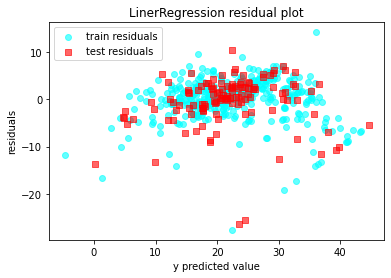

In [14]:
#線形モデルを診断するときに、残差プロットをして、残差が正規分布っぽく分布しているかどうかを確認する方法がある
plt.scatter(y_train_pred, y_train_pred - y_train, c='cyan',marker='o',label='train residuals',alpha=.6)
plt.scatter(y_test_pred, y_test_pred - y_test, c='red',marker='s',label='test residuals',alpha=.6)
plt.xlabel('y predicted value')
plt.ylabel('residuals')
plt.title('LinerRegression residual plot')
plt.legend()
#残差が残念ながら正規分布っぽく分布していないので、このモデルは改良の余地ありということになる

In [15]:
#MSE on train/test
#MSEはモデルの汎か性能を測る指標であるが、特徴量のスケール次第で絶対値は変わるので、値の大きさで判断することはできない
print('MSE')
print('train',mean_squared_error(y_train,y_train_pred))
print('test',mean_squared_error(y_test,y_test_pred))

#値のスケールに依存しない性能評価として、r2_scoreがある
print('R2')
print('train',r2_score(y_train,y_train_pred))
print('test',r2_score(y_test,y_test_pred))

#いずれの指標でもtestの値がtrainよりも小さく、過学習気味であることがわかる

MSE
train 19.640519427908043
test 29.78224509230234
R2
train 0.7697699488741149
test 0.6354638433202132


In [16]:
#というわけで、汎か性能を確保するために、モデルの重みにペナルティをかけるため、RidgeとLasso,elasticnetという3つの正則化線形回帰を導入
from sklearn.linear_model import Lasso,Ridge,ElasticNet

ridge = Ridge(alpha=1.5)
lasso = Lasso(alpha=1.5)
enet = ElasticNet(alpha=1.0,l1_ratio=0.5)

#ridge
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

print('RIDGE')
print('MSE')
print('train',mean_squared_error(y_train,y_train_pred))
print('test',mean_squared_error(y_test,y_test_pred))

#値のスケールに依存しない性能評価として、r2_scoreがある
print('R2')
print('train',r2_score(y_train,y_train_pred))
print('test',r2_score(y_test,y_test_pred))

#lasso
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print('LASSO')
print('MSE')
print('train',mean_squared_error(y_train,y_train_pred))
print('test',mean_squared_error(y_test,y_test_pred))

#値のスケールに依存しない性能評価として、r2_scoreがある
print('R2')
print('train',r2_score(y_train,y_train_pred))
print('test',r2_score(y_test,y_test_pred))


RIDGE
MSE
train 19.87659671763834
test 30.712417045197867
R2
train 0.7670026042178918
test 0.6240784924942775
LASSO
MSE
train 26.91242791482918
test 39.57625016993785
R2
train 0.6845272001335875
test 0.5155847355350733


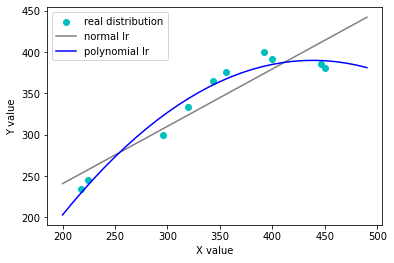

In [44]:
#ここまでは、すべて線形の関係を仮定して回帰式を作ってきたが、多項式回帰を使うことでモデルの表現力があがあることがある
from sklearn.preprocessing import PolynomialFeatures

#sample
X = np.array([218,224,296,320,343,356,392,400,446,450])[:,np.newaxis]
y = np.array([234,245,299,334,365,376,400,392,385,380])

#線形回帰インスタンス化
lr = LinearRegression()
pr = LinearRegression()

#2次の多項式特徴を追加するインスタンス
quadratic = PolynomialFeatures(degree=2)
#2次の特徴量生成
X_quad = quadratic.fit_transform(X)

#普通の線形回帰を学習させる
lr.fit(X,y)

#テキトーな値をぶっこんで予測値をはかせる
nb = np.arange(200,500,10)[:,np.newaxis]
y_pred_lr = lr.predict(nb)

#多項式回帰を学習させる
pr.fit(X_quad,y)
#同じくテキトーな値をぶっこむ、で予測する
y_pred_pr = pr.predict(quadratic.fit_transform(nb))#ただし投入する特徴量をPolynomialFeaturesにぶち込んで、二次までの特徴量を追加しておく

#描画
plt.scatter(X,y,c='c',label='real distribution')
plt.plot(nb,y_pred_lr,lw='1.5',c='gray',label='normal lr')

plt.plot(nb,y_pred_pr,lw='1.5',c='blue',label='polynomial lr')
plt.xlabel('X value')
plt.ylabel('Y value')
plt.legend()

#非線形な分布の場合、見ての通り多項式回帰がうまくfitすることがわかる

In [49]:
#次に評価指標として、R2スコアが単項式と多項式でどう違うのかを見る
y_pred_lr = lr.predict(X)
y_pred_pr = pr.predict(X_quad)
print('単項式のR2: {:.3f}'.format(r2_score(y,y_pred_lr)))

print('多項式のR2: {:.3f}'.format(r2_score(y,y_pred_pr)))#多項式のほうが、R2スコアが高い、つまりyの分布をよりよく表すことができるモデルということになる

単項式のR2: 0.859
多項式のR2: 0.962


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


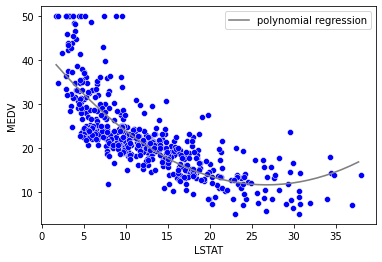

In [70]:
#Housingデータにもどり、多項式の適用余地があるか？を確認する

#LSTATのみによって、MEDVMEDVが説明できるとする(散布図的にも非線形の関係があるのは明らか)
X = df[['LSTAT']].values
y = df.MEDV

lrl = LinearRegression()

#多項式で2次まで特徴量追加
poly = PolynomialFeatures(degree=2)
Xpoly = poly.fit_transform(X)

#2次の項で回帰
lrl.fit(Xpoly,y)

y_pred_poly = lrl.predict(poly.fit_transform(np.arange(X.min(),X.max(),1)[:,np.newaxis]))

#plot
sns.scatterplot(X.flatten(),y,color='b')
plt.plot(np.arange(X.min(),X.max(),1),y_pred_poly,lw='1.6',c='gray',label='polynomial regression')
plt.xlabel('LSTAT')
plt.ylabel('MEDV')
plt.legend()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


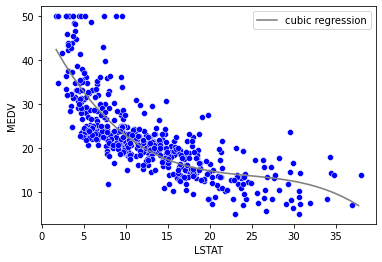

In [71]:
#3次の多項式
lrl3 = LinearRegression()

#多項式で3次まで特徴量追加
poly = PolynomialFeatures(degree=3)
Xpoly = poly.fit_transform(X)

#2次の項で回帰
lrl3.fit(Xpoly,y)

y_pred_poly = lrl3.predict(poly.fit_transform(np.arange(X.min(),X.max(),1)[:,np.newaxis]))

#plot
sns.scatterplot(X.flatten(),y,color='b')
plt.plot(np.arange(X.min(),X.max(),1),y_pred_poly,lw='1.6',c='gray',label='cubic regression')
plt.xlabel('LSTAT')
plt.ylabel('MEDV')
plt.legend()

多項式の次数をあげていけば、非線形な関係にうまくFITできるようになるが、同時に過学習のリスクも上がることを理解しておく
<br>LSTATとMEDVの関係性を散布図で見ると、MEDV = e^(-LSTAT)という関係性があるようにみえるので、log(MEDV) = -LSTATとなる。<br>
つまりxとyをそれぞれlog変換するとどうなるか

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


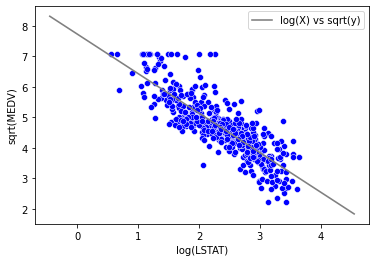

In [86]:
lr4 = LinearRegression()

#Xはlogをとり、yは平方根をとる
X_log = np.log(X)
y_sqrt = np.sqrt(y)

#fit
lr4.fit(X_log,y_sqrt)

#predict
y_pred_log = lr4.predict(np.arange(X_log.min()-1,X_log.max()+1,1)[:,np.newaxis])

#plot
sns.scatterplot(X_log.flatten(),y_sqrt,color='b')
plt.plot(np.arange(X_log.min()-1,X_log.max()+1,1),y_pred_log,lw='1.6',c='gray',label='log(X) vs sqrt(y)')
plt.xlabel('log(LSTAT)')
plt.ylabel('sqrt(MEDV)')
plt.legend()

In [87]:
#このように、非線形関係があった場合、特徴量に対してeを底とした指数関数のような分布になっているのであれば、
#特徴量をlog変換することで、線形の関係性に持ち込むこともできる